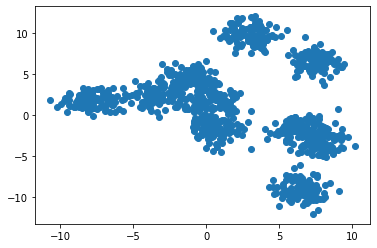

In [1]:
# 実装

# ライブラリimport
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns

# data用意
X, y = make_blobs(n_samples=1000, centers=10, cluster_std=1, n_features=2,random_state=6)

# data可視化

plt.scatter(X[:,0], X[:,1])




In [2]:
# 2. k-meansの距離関数を、ロードの差関数に変更。
# k-means自体のアルゴリズムを拡張
import itertools 

# load function
def load(num, alpha, variance):
    return alpha * num + (1-alpha) * np.linalg.norm(variance)

# load delta
def load_delta(n, alpha, node, variance, mean):
    mean_1 = (n*mean + node)/(n+1)
    var_1 = (n*(variance+np.square(mean)) + np.square(node))/(n+1) - np.square(mean_1)
    delta_var = var_1 - variance

    return alpha + (1-alpha) * np.linalg.norm(delta_var)

def kload2(data, alpha=0.5,k=4, max_iter=10,random_seed=1):
    #指定したクラスター数分のラベルを繰り返し作成するジェネレータを生成（0,1,2,0,1,2,0,1,2...みたいな感じ
    cycle = itertools.cycle(range(k))
    #各データポイントに対してクラスタのラベルをランダムに割り振る
    labels = np.fromiter(itertools.islice(cycle, data.shape[0]), dtype = int)
    random_state = np.random.RandomState(random_seed)
    random_state.shuffle(labels)
    
    labels_prev = np.zeros(data.shape[0])
    count = 0
    cluster_centers = np.zeros((k, data.shape[1]))
    variances = np.zeros((k, data.shape[1]))
    cluster_sizes = np.zeros(k)
    loads = np.zeros(k)
    
    # クラスタの変化がない、or 最大回数
    while (not np.array_equal(labels, labels_prev) and (count < max_iter)):
        # 判定用変数
        labels_prev = labels.copy()
        count += 1
        
        #その時点での各クラスターの重心を計算する

        
        for j in range(k):
            cluster_nodes = data[labels == j, :]
            cluster_sizes[j] = cluster_nodes.shape[0]
            if cluster_sizes[j] == 0:
                pass
                # variances[j, :] = 0
                # cluster_centers[j, :] = 0
            else:
                variances[j, :] = np.nanvar(cluster_nodes, axis=0)
                cluster_centers[j, :] = np.nanmean(cluster_nodes, axis = 0)
            loads[j] = load(cluster_sizes[j], alpha, variances[j])
            
        #各データポイントと各クラスターの重心間の距離を総当たりで計算する
        
        for i, x in enumerate(data):
            deltas = np.zeros(k)
            for j in range(k):
                # 1 o(1) ロードの差を計算する方法　　
                # deltas[j] = load_delta(cluster_sizes[j], alpha, x, variances[j], cluster_centers[j])
                
                # 2 loadsを再計算する方法
                # o(n/k) 計算量爆発するし、収束しない
                # cluster_nodes = data[labels == j, :]
                # cluster_size = cluster_nodes.shape[0]
                # variance = np.nanvar(cluster_nodes, axis=0)
                # deltas[j] = load(cluster_size, alpha, variance)
                
                # 3 中心点からの距離の方法
                deltas[j] = np.linalg.norm(cluster_centers[j] - x)
            # print(deltas)
            labels[i] = np.argmin(deltas)
            
        # print('cond', np.array_equal(labels, labels_prev), count<max_iter)
        # print(labels_prev[:10], labels[:10])
        # print(count)
        # print("v",variances)
        # print("num",cluster_sizes)
        # print("c", cluster_centers)
        # print("load",loads, np.sum(loads))
        # print(np.var(loads))
    # end while
    return count, cluster_sizes, loads, np.var(loads)

kload2(data=X[:1000], alpha=0.6, k=5, max_iter=50,random_seed=5)

(19,
 array([366., 101., 101., 301., 131.]),
 array([222.25168888,  61.18316391,  61.2237478 , 185.00291846,
         79.83970835]),
 4637.929935785151)

In [3]:
# 実験
# ロードの分散を調べる。どれだけいいモデルができたか

print("\nalpha の値を変えて比較")
alphas=[0.01,0.1,0.3,0.5,0.8,0.9,0.99]
for alpha in alphas:
    print(kload2(data=X[:100], alpha=alpha, k=5, max_iter=50,random_seed=5))

print("\nデータの数を変えて比較")
nums=[10,100,500,1000]
for num in nums:
    print(kload2(data=X[:num], alpha=0.8, k=5, max_iter=50,random_seed=4))
    # %timeit kload2(data=X[:num], alpha=0.8, k=5, max_iter=50,random_seed=4)

print("\n初期のランダムネスを変えて比較")

for num in range(10):
    print(kload2(data=X[:100], alpha=0.8, k=5, max_iter=50,random_seed=num))

# 計算速度、使えるモデルができたか


alpha の値を変えて比較
(7, array([17., 14., 30., 18., 21.]), array([ 2.45295443,  3.92853302, 11.08170805,  6.98511272,  2.12577432]), 11.265790811939308)
(7, array([17., 14., 30., 18., 21.]), array([ 3.77541312,  4.84412093, 12.80155278,  7.98646611,  3.84161302]), 11.80784589462137)
(7, array([17., 14., 30., 18., 21.]), array([ 6.7142102 ,  6.87876072, 16.62342994, 10.21169586,  7.6545879 ]), 13.843785349017391)
(7, array([17., 14., 30., 18., 21.]), array([ 9.65300729,  8.91340051, 20.4453071 , 12.43692562, 11.46756279]), 17.026445636505034)
(7, array([17., 14., 30., 18., 21.]), array([14.06120292, 11.96536021, 26.17812284, 15.77477025, 17.18702512]), 23.950537629783295)
(7, array([17., 14., 30., 18., 21.]), array([15.53060146, 12.9826801 , 28.08906142, 16.88738512, 19.09351256]), 26.831928710755186)
(7, array([17., 14., 30., 18., 21.]), array([16.85306015, 13.89826801, 29.80890614, 17.88873851, 20.80935126]), 29.670292261703235)

データの数を変えて比較
(2, array([3., 2., 3., 1., 1.]), array([2.659864

In [25]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(formatter={'float': '{:.2f}'.format})

from sklearn.cluster import KMeans

# 各種パラメータ定義
# load function

def load(points, alpha):
    variance = np.var(points, axis=0) # o(n)
    return alpha * points.shape[0] + (1-alpha) * np.linalg.norm(variance)

def find_outmost_idx(data, center,j, labels):
    all_norms = np.linalg.norm(data - center, axis=1)
    idxs = np.array(np.where(labels == j)).flatten()
    tmp_idx = np.argmax(all_norms[idxs])
    return idxs[tmp_idx]

# k-means 1の方法
# radiusは収束半径
# 調整用最大クラスタ数 adj_k
def kload(data, alpha=0.5, k=2, radius=0.1,  max_iter=10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data)
    
    labels = np.copy(kmeans.labels_)
    inertia = kmeans.inertia_
    centers = kmeans.cluster_centers_

    iter_count = 0
    radius_prev = np.inf
    delta_prev = np.inf
    delta_load = np.inf
    while True: 
        iter_count += 1

        # クラスタ再配置 based on load func
        clusters = [ data[labels==j] for j in range(0,k)]
        loads = np.array([load(cluster, alpha) for cluster in clusters])
        # print("loads", loads)

        # ロードの計算
        max_cluster_idx = np.argmax(loads)
        min_cluster_idx = np.argmin(loads)
        max_load = loads[max_cluster_idx]
        min_load = loads[min_cluster_idx]
        
        minmax_load = max_load / min_load
        variance_load = np.linalg.norm(np.var(loads))
        
        # ロードの合計
        sum_load = loads.sum()

        delta_load = minmax_load

        if (radius_prev < radius and delta_load < delta_prev) | (max_iter < iter_count):
            break
        radius_prev = abs(delta_load - delta_prev)
        delta_prev = delta_load

        
        # 1. 最大クラスタの大きい点を次に近いクラスタに移す。
#         outmost_idx = find_outmost_idx(data, centers[max_cluster_idx],max_cluster_idx, labels)

#         centers_wo_belong = np.copy(centers)
#         centers_wo_belong[max_cluster_idx] = np.full(data.shape[1], np.inf)

#         nearest_cluster_idx = np.argmin(np.linalg.norm(centers_wo_belong - data[outmost_idx], axis=1))
#         labels[outmost_idx] = nearest_cluster_idx

        # 2. クラスタの大きい順で、最大クラスタAから一番近いクラスタB、AのBに一番近い点を移す。
        
        # 最後のクラスタ以外の場合 -1
        # 最初のクラスタだけの場合　1 こっちだけで良さそう
        cluster_sorted_idxs = np.argsort(-loads)[:1]
        
        for moval_cluster_idx in cluster_sorted_idxs:
        
            # 最大クラスタA
            # clusters[moval_cluster_idx]

            # Aに一番近いクラスタB o(k)
            centers_wo_belong = np.copy(centers)
            centers_wo_belong[moval_cluster_idx] = np.full(data.shape[1], np.inf)
            nearest_cluster_idx = np.argmin(np.linalg.norm(centers_wo_belong - centers[moval_cluster_idx], axis=1))

            # AのBに一番近い点 o(n/k)
            idxs = np.array(np.where(labels == moval_cluster_idx)).flatten()
            tmp_idx =  np.argmin(np.linalg.norm(data[labels == moval_cluster_idx] - centers[nearest_cluster_idx], axis=1))
            nearest_point_idx = idxs[tmp_idx]

            # 点をBに移す
            labels[nearest_point_idx] = nearest_cluster_idx
        

        print(iter_count, delta_load)
    return (iter_count, labels, loads, minmax_load, variance_load, sum_load)




In [26]:
# 素のkmeans load
def plane_kmeans(k, alpha, data):
    kmeans = KMeans(n_clusters=k,random_state=1).fit(data)
    
    labels = np.copy(kmeans.labels_)
    inertia = kmeans.inertia_
    centers = kmeans.cluster_centers_
    
    # クラスタ再配置 based on load func
    clusters = [ data[labels==j] for j in range(0,k)]
    loads = np.array([load(cluster, alpha) for cluster in clusters])
    # print("loads", loads)

    # ロードの計算
    max_cluster_idx = np.argmax(loads)
    min_cluster_idx = np.argmin(loads)
    max_load = loads[max_cluster_idx]
    min_load = loads[min_cluster_idx]

    minmax_load = max_load / min_load
    variance_load = np.linalg.norm(np.var(loads))
    
    sum_load = loads.sum()
    
    
    return (0, labels, loads, minmax_load, variance_load, sum_load)


k= 2
分類用データ 
1 1.9908256179694235
2 1.9820601324267049
k= 3
分類用データ 
1 2.4358472200507517
2 2.4184944457157544
3 2.401333417958677
4 2.3839134751688538
5 2.3667782228617473
6 2.3497790272132457
7 2.3329661887917994
8 2.3164241308020657
9 2.2998429492145327
10 2.283369645806175
11 2.2672760245182917
12 2.251335908965433
13 2.235478218625894
14 2.2197124415615326
15 2.20444730161927
16 2.1890192396542103
17 2.1738718271579014
18 2.1590139373820074
19 2.1442857028883284
20 2.1295964533355853
21 2.1150361927264467
22 2.1007435645402976
23 2.0866466862659085
24 2.072406683919773
25 2.0583970938440883
26 2.0445516208865753
27 2.0308073969622424
28 2.0171617783741973
29 2.003659015911732
30 1.990211797624794
31 1.977092122458638
32 1.9639527521570532
33 1.9510262849209068
34 1.9383038808637254
35 1.925643099234902
36 1.9129540298827397
37 1.900362539139371
38 1.887936719247067
39 1.875734091545365
40 1.8636436151125637
41 1.8516754828641264
42 1.839779381880178
43 1.8280259568024138
44 1.81625

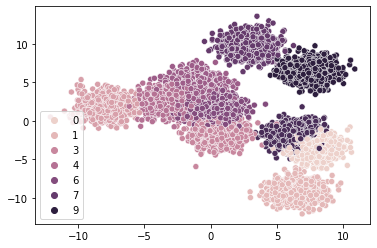

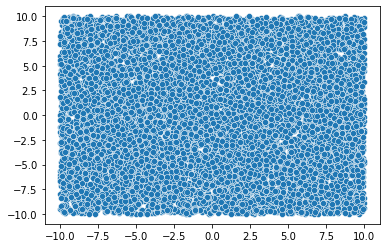

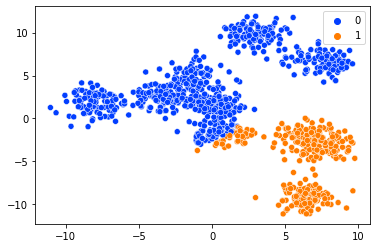

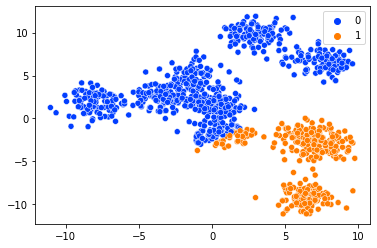

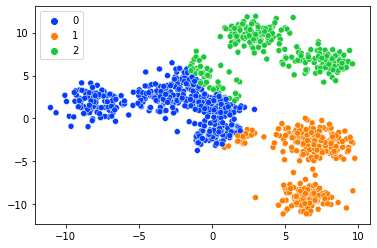

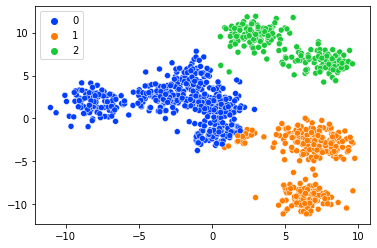

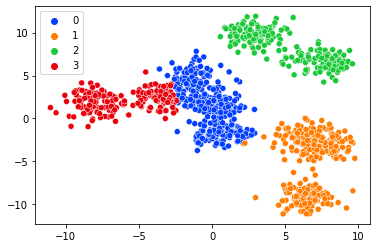

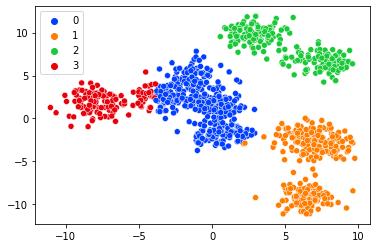

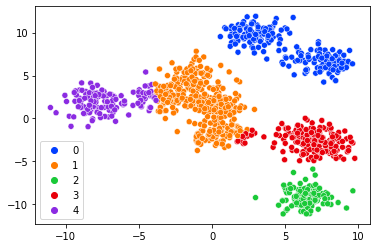

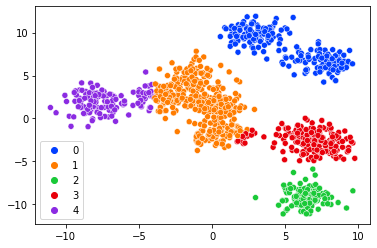

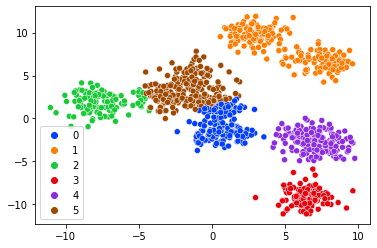

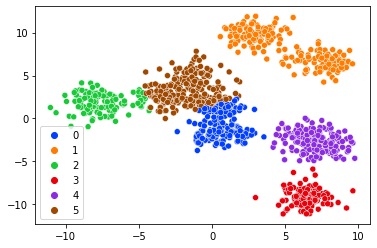

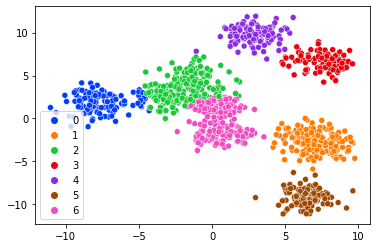

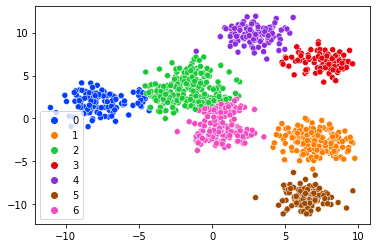

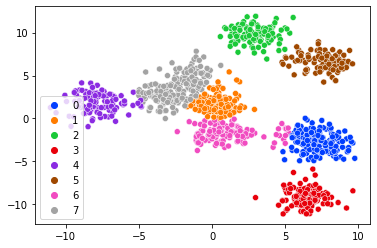

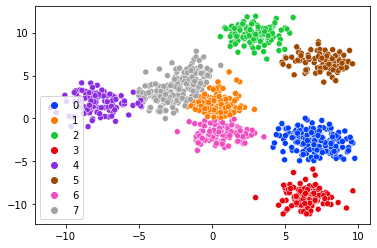

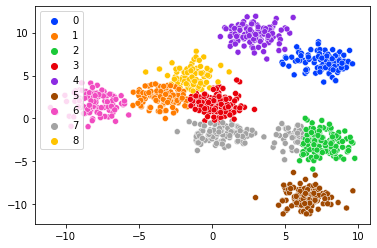

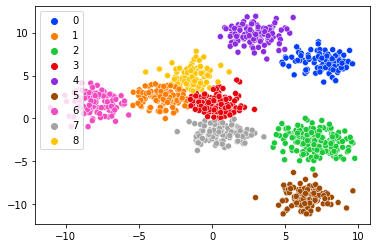

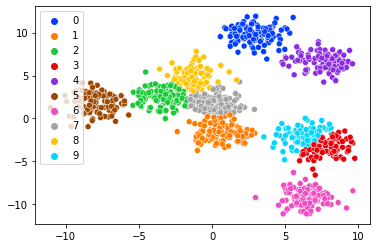

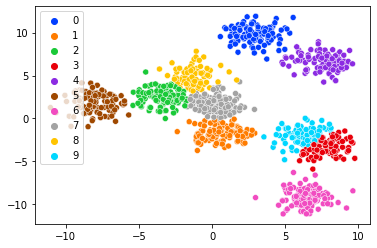

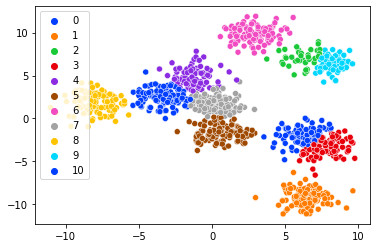

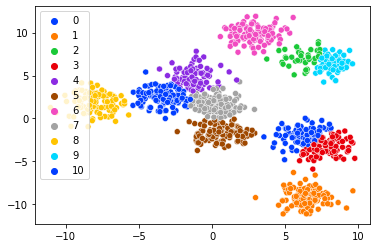

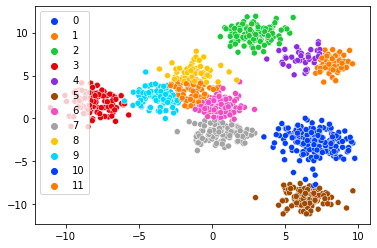

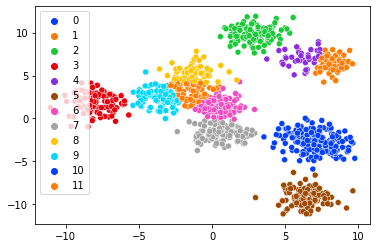

In [27]:


# 分類用 data　isotropic Gaussian blobs for clustering
X, y = make_blobs(n_samples=10000, centers=10, cluster_std=1, n_features=2,random_state=6)

plt.figure()
sns.scatterplot(x=X[:,0], y=X[:,1],hue=y)

# 一様分布 (-10, 10)
X2 = (10+10)* np.random.rand(10000,2) - 10

plt.figure()
sns.scatterplot(x=X2[:,0], y=X2[:,1])

# alpha = 0.6, n=1000
for _, k in enumerate(range(2,13)):
    
    print("k=",k)

    print("分類用データ ")

    res = kload(data=X[:1000], alpha=0.6, k=k, radius=0.01, max_iter=50 )
    plt.figure()
    sns.scatterplot(x=X[:1000,0], y=X[:1000,1], hue=res[1], palette='bright')

    res = plane_kmeans(k=k, alpha=0.6, data=X[:1000])
    plt.figure()
    sns.scatterplot(x=X[:1000,0], y=X[:1000,1], hue=res[1], palette='bright')

#     print("一様分布データ")

#     print(kload(data=X2[:1000], alpha=0.6, k=k, radius=0.01, max_iter=20 ))
#     print(plane_kmeans(k=k, alpha=0.6, data=X2[:1000]))

    
# この結果から、どちらのデータの場合も、kを変えたとしても、kloadのほうが均等に近いロードを出してる方が多い。たまに失敗している。


# alphaを変えた場合, k=6
alphas= [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]

# print("alphaを変えた場合")
# for _, alpha in enumerate(alphas):
    
#     print("alpha=",alpha)

#     print("分類用データ ")

#     print(kload(data=X[:1000], alpha=alpha, k=6, radius=0.01, max_iter=20 ))
#     print(plane_kmeans(k=6,alpha=alpha, data=X[:1000]))

#     print("一様分布データ")

#     print(kload(data=X2[:1000], alpha=alpha, k=6, radius=0.01, max_iter=20 ))
#     print(plane_kmeans(k=6,alpha=alpha, data=X2[:1000]))

# alphaによってより均等になる場合がある。うまくalphaを設定する必要がある。

# 評価. 可視化、ロードの分散具合、計算量、
# k, alpha, データ数, 次元数を変えてみて

# 発展
# ロード関数を変えれば、重みつきのデータにも対応。
# クラスタ入れ替え時に、一つではなくbulkでもいい

plt.show()

alphaを変えた場合
1 3.7155185911551643
2 3.705321044070772
3 3.687928492307442
4 3.673980854795102
5 3.674742569523279
1 2.0986121640862145
2 2.0894538015049955
1 2.006030523848476
2 1.997250247688461
1 2.00262616255493
2 1.993762170504725
1 2.001133326027851
2 1.9922326239671628
1 2.0002949649710424
2 1.9913736469603653
1 2.000026848132796
2 1.9910989369206775
1 1.8183473982756613
2 1.8161188054780881
1 1.7983239855467796
2 1.792581333988787
1 1.7912862067266944
2 1.7843084426206328
1 1.7894186509919
2 1.782113135533994
1 1.7885545026959448
2 1.7810973313774316
1 1.7880563307082746
2 1.7805117314542154
1 1.7878949975432208
2 1.7803220847229542
kを変えた場合
1 2.0161860041968596
2 2.0079469509279835
1 2.344606806685183
2 2.3277299464444448
3 2.3111101816489033
4 2.2924530434192616
5 2.2745616116687226
6 2.2566784806943567
7 2.239072810240408
8 2.2221821448511534
9 2.2044336910008115
10 2.1865865716780735
11 2.170046699201659
12 2.153661858275168
13 2.137079204826192
14 2.120354100610336
15 2.10555

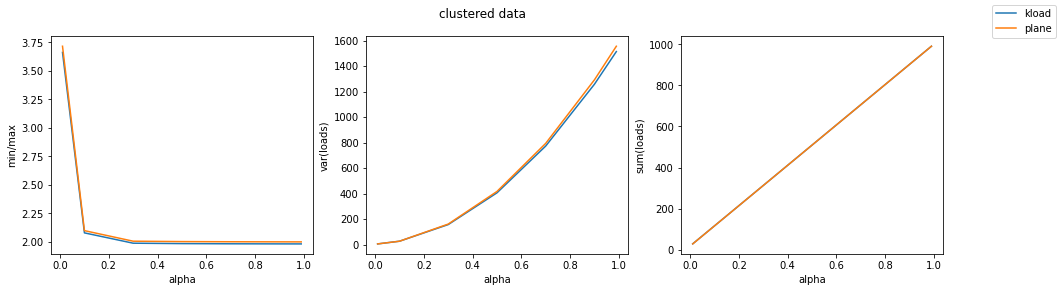

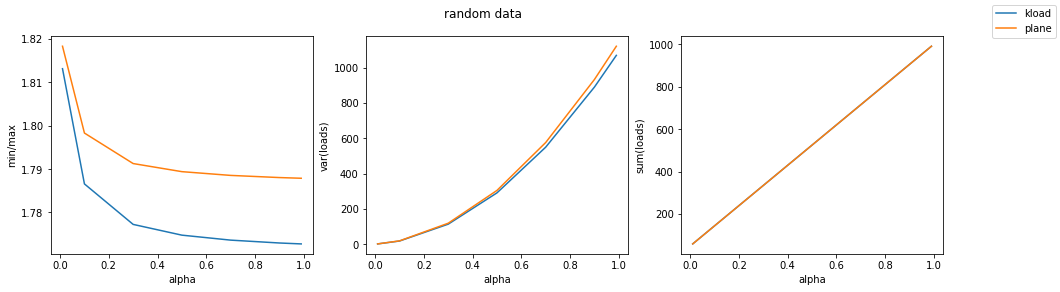

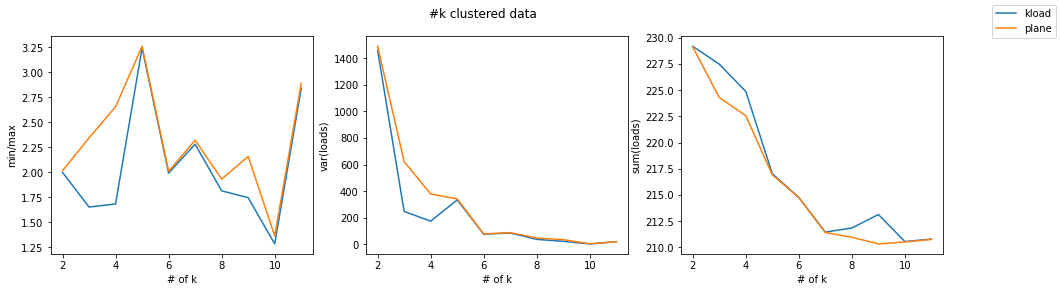

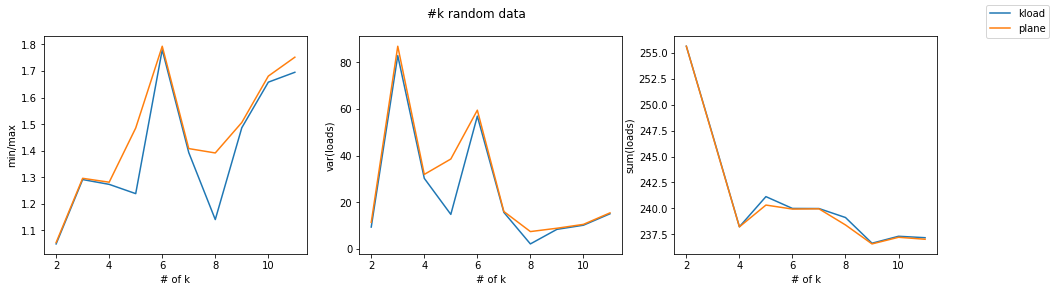

In [28]:
def plot_3(title, xdata, xlabel, result_prp, result_org):
    fig, axes = plt.subplots(1,3, sharex=True, figsize=(16,4))
    ax = axes.ravel()
    
    fig.suptitle(title)
    
    ax[0].plot(xdata, result_prp[:, 3], label='kload')
    ax[0].plot(xdata, result_org[:, 3], label='plane')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel("min/max")
    fig.legend()  

    ax[1].plot(xdata, result_prp[:, 4])
    ax[1].plot(xdata, result_org[:, 4])
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel("var(loads)")

    ax[2].plot(xdata, result_prp[:, 5])
    ax[2].plot(xdata, result_org[:, 5])
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel("sum(loads)")
    return fig, ax

# alphaを変えた場合, k=6

print("alphaを変えた場合")

def plots_alpha_change(data, k, title):
    alphas= [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
    result_prp = np.array([ kload(data=data, alpha=alpha, k=k, radius=0.01, max_iter=50 ) for  alpha in alphas])
    result_org = np.array([ plane_kmeans(data=data, alpha=alpha, k=k) for  alpha in alphas])

    plot_3(title, alphas, 'alpha', result_prp, result_org)

plots_alpha_change(data=X[:1000], k=6, title="clustered data")
plots_alpha_change(data=X2[:1000], k=6,title="random data")

print("kを変えた場合")

def plots_k_change(data, title, alpha=0.2):

    knums = range(2,12)
    
    result_prp = np.array([ kload(data=data, alpha=alpha, k=k, radius=0.01, max_iter=50 ) for  k in knums])
    result_org = np.array([ plane_kmeans(data=data, alpha=alpha, k=k)  for  k in knums])

    plot_3(title, knums, '# of k', result_prp, result_org)

plots_k_change(data=X[:1000], title="#k clustered data")
plots_k_change(data=X2[:1000], title="#k random data")





# for _, alpha in enumerate(alphas):
    
#     print("alpha=",alpha)


#     print(kload(data=X[:1000], alpha=alpha, k=6, radius=0.01, max_iter=20 ))
#     print(plane_kmeans(k=6,alpha=alpha, data=X[:1000]))

#     print("一様分布データ")

#     print(kload(data=X2[:1000], alpha=alpha, k=6, radius=0.01, max_iter=20 ))
#     print(plane_kmeans(k=6,alpha=alpha, data=X2[:1000]))

クラスタデータのcentersの値を変えた場合
1 1.637533627192149
2 1.631412263015992
1 2.241446390050901
2 2.2345757515415725
1 2.095276878118296
2 2.096638176014448
1 1.0192436477908533
2 1.012877198150586
1 1.9874706062290692
2 1.9813635467119828
1 2.2774453004673263
2 2.270595188666756
1 2.3773702692356986
2 2.3696591407646697
1 3.636692381803902
2 3.628429390687249
1 3.7283917143675445
2 3.719278475105396
1 3.859757078474603
2 3.8492817773952317
3 3.8390892210084226
4 3.8285329945040756
5 3.818463722972672
6 3.8082286712512476
7 3.7981761439060846
8 3.7880482454405473
9 3.7780215680163414
10 3.7679884343055328
11 3.757986257581051
12 3.7478925076054574
13 3.737391770599662
14 3.7273282714062477
15 3.7172309370942926
16 3.707197622378861
17 3.6970726689109243
18 3.68705869188726
19 3.67712838509194
1 1.2301361216757747
2 1.2156120011591924
3 1.2012752762339391
4 1.1871192883469293
5 1.1731479684320962
6 1.1593328010472366
7 1.1457150670548308
8 1.1322405617487399
9 1.1189557208424927
10 1.10674502494080

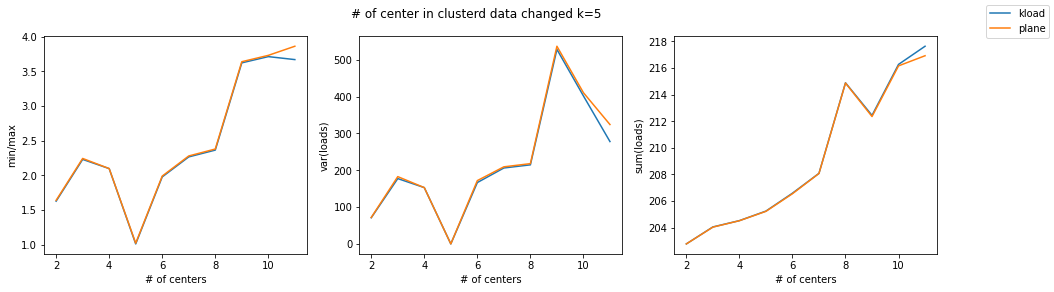

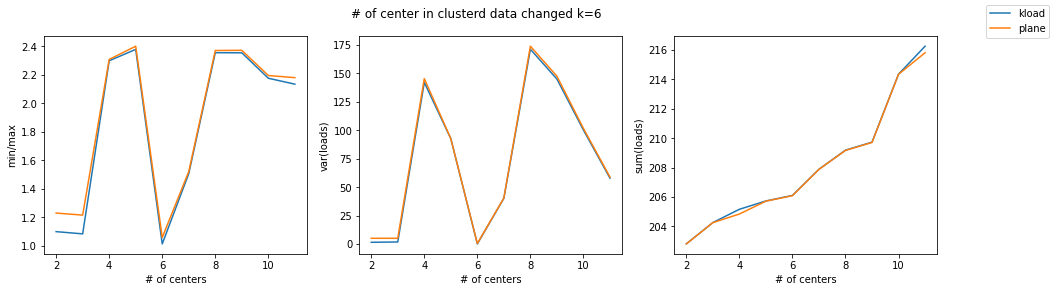

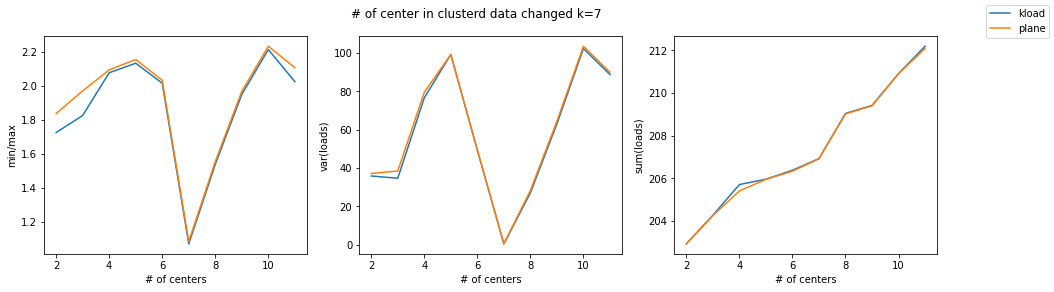

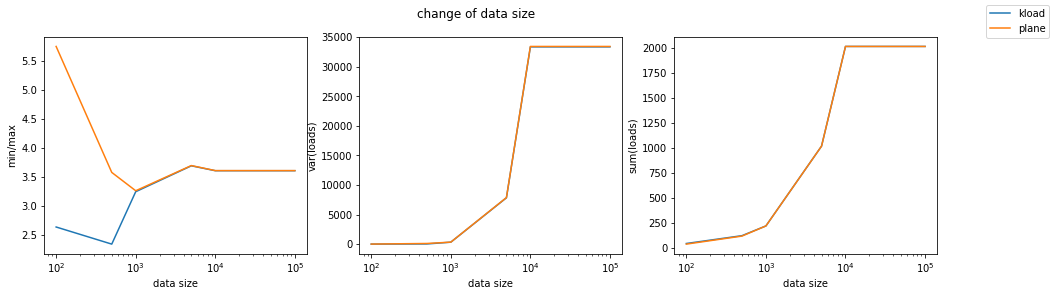

In [29]:
print("クラスタデータのcentersの値を変えた場合")


def plots_centers_change(title, k=6, alpha=0.2):
    center_nums = range(2,12)
    
    def build_data(n):
        X, _ = make_blobs(n_samples=1000, centers=n, cluster_std=1, n_features=2,random_state=6)
        return X
    
    result_prp = np.array([ kload(data=build_data(n), alpha=alpha, k=k, radius=0.01, max_iter=50 ) for n in center_nums])
    result_org = np.array([ plane_kmeans(data=build_data(n), alpha=alpha, k=k)  for n in center_nums])

    plot_3(title, center_nums, '# of centers', result_prp, result_org)
    
plots_centers_change('# of center in clusterd data changed k=5', k=5) 
plots_centers_change('# of center in clusterd data changed k=6', k=6) 
plots_centers_change('# of center in clusterd data changed k=7', k=7) 

print("データの数を変えた場合")

def plots_data_change(data, title='change of data size', k=5, alpha=0.2):
    nums=[100, 500,1000, 5000, 10000, 50000, 100000]
    
    
    result_prp = np.array([ kload(data=data[:n], alpha=alpha, k=k, radius=0.01, max_iter=50 ) for n in nums])
    result_org = np.array([ plane_kmeans(data=data[:n], alpha=alpha, k=k)  for n in nums])
    
    fig, ax = plot_3(title, nums, 'data size', result_prp, result_org)
    plt.xscale('log')

plots_data_change(data=X)

# speed

# todo

center= 12 k= 2
center= 11 k= 3
center= 10 k= 4
center= 9 k= 5
center= 8 k= 6
center= 7 k= 7
center= 6 k= 8
center= 5 k= 9
center= 4 k= 10
center= 3 k= 11
center= 2 k= 12


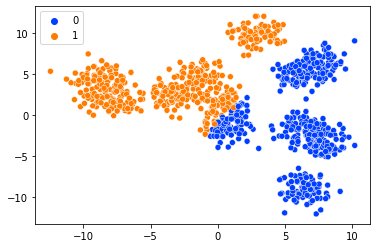

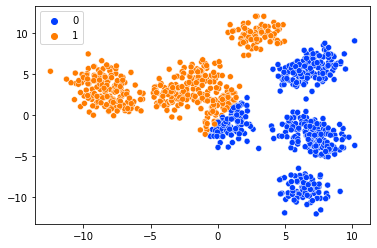

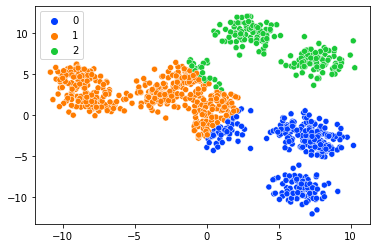

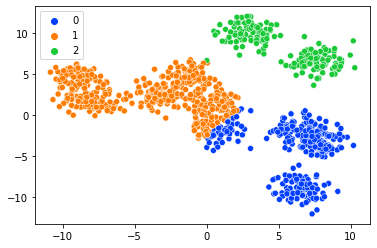

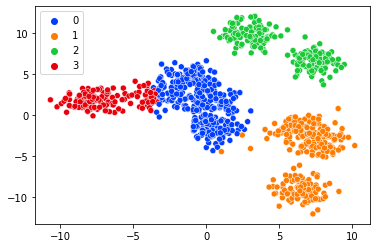

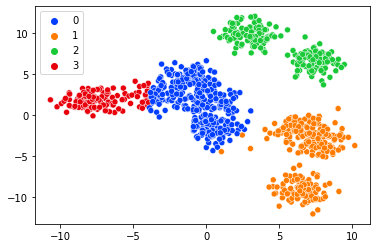

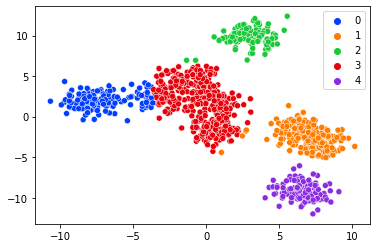

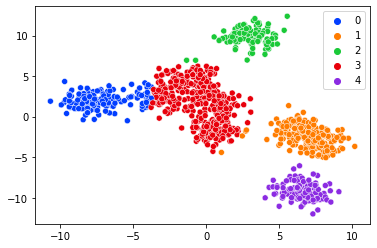

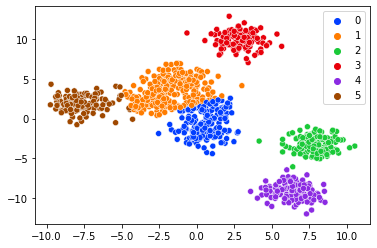

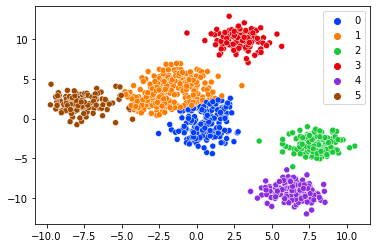

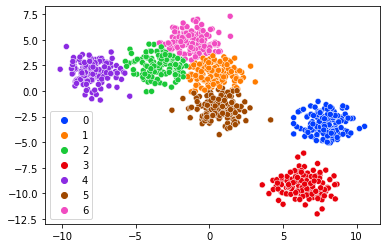

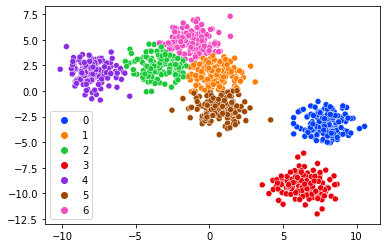

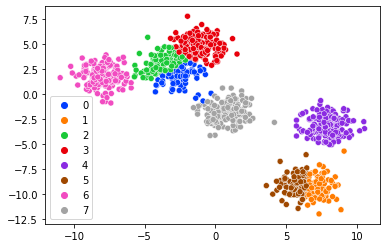

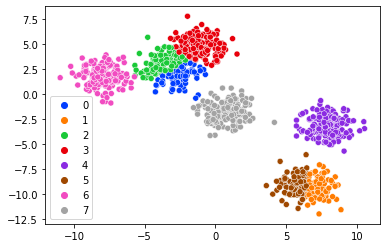

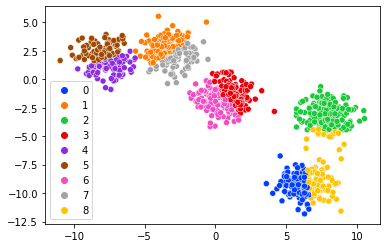

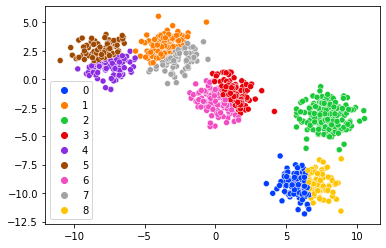

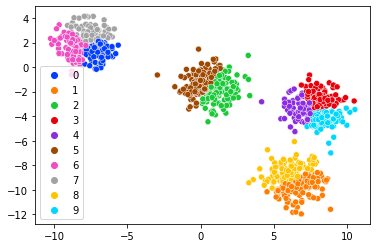

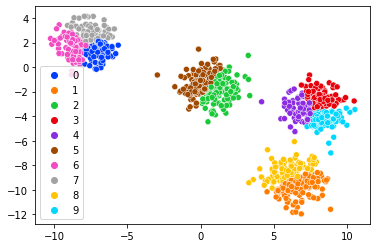

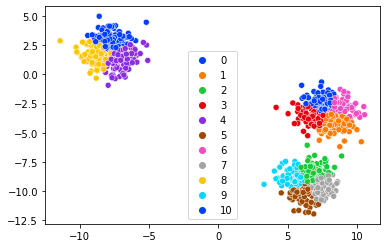

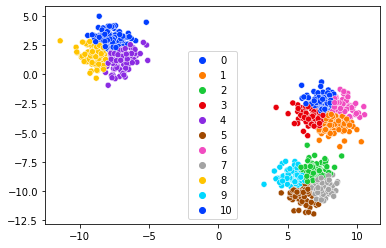

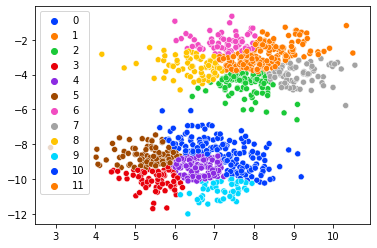

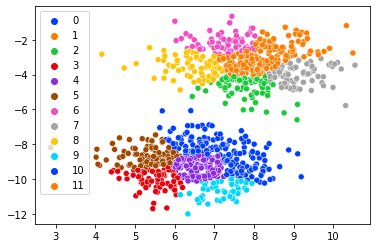

In [9]:


# 分類用データの中心点の数と、kを増減した時のちがい
for _, k in enumerate(range(2,13)):
    centern = 14 - k
    print("center=",centern,"k=",k)
    
    X, _ = make_blobs(n_samples=1000, centers=centern, cluster_std=1, n_features=2,random_state=6)


    res = kload(data=X[:1000], alpha=0.6, k=k, radius=0.01, max_iter=20 )
    plt.figure()
    sns.scatterplot(x=X[:1000,0], y=X[:1000,1], hue=res[1], palette='bright')
    
    res = plane_kmeans(k=k, alpha=0.6, data=X[:1000])
    plt.figure()
    sns.scatterplot(x=X[:1000,0], y=X[:1000,1], hue=res[1], palette='bright')
    


In [10]:
print('データ数による違い 速度')
nums=[500,1000, 10000]
for i, num in enumerate(nums):
    for j, k in enumerate(range(5,8)):
        print('num',num,'k', k)
        print('kload')
        %timeit -r 2 -n 10 kload(data=X[:num], alpha=0.9, k=k, radius=0.01, max_iter=100 )
        print('plane kmeans')
        %timeit -r 2 -n 10 plane_kmeans(k=k, alpha=0.9, data=X[:num])
        
        

データ数による違い 速度
num 500 k 5
kload
47.7 ms ± 4.38 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
39.5 ms ± 2.64 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 500 k 6
kload
48.6 ms ± 2.79 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
47.4 ms ± 233 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 500 k 7
kload
53.8 ms ± 3.39 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
47 ms ± 2.71 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 1000 k 5
kload
65.1 ms ± 54.7 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
61.9 ms ± 2.48 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 1000 k 6
kload
77.8 ms ± 76.2 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
66.7 ms ± 1.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
num 1000 k 7
kload
80.5 ms ± 8.7 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
plane kmeans
75 ms ± 703 µs per loo

In [11]:
- アルゴリズムの改良
- 速度のグラフ
- 偏りがあるクラスタデータでの性能比較


NameError: name 'アルゴリズムの改良' is not defined